<a target="_blank" href="https://colab.research.google.com/github/ArtificialIntelligenceToolkit/aitk/blob/master/notebooks/GenerativeAI/NanoGPT.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NanoGPT - A Small-Scale Large Lanaguge Model Using Shakespeare

## Introduction

In this notebook, we want to walk you through a simple large language model that is trained using all of Shakespeare's plays. This model is called NanoGPT, a tiny large language model developed by Andrej Karpathy (see below for the reference to his github repo).

Before delving into the model, let's first provide some insights into how a Large Language Model (LLM) operates. At the core of an LLM lies the Transformer architecture, which is the key component responsible for the remarkable capabilities of LLMs. In this context, the main job of the transformer is to predict the next token (you can think of a token as a word) based on the input sequence so far.

The newly predicted token will be added to the old input sequence. This updated input sequence will then be used to predict another new token. We will continue doing this until a desirable end is reached.

Let us explain what we mean using an example:

(1) Let's say the initial inputs is "To be, or". We will pass this input into the transformer and predict the word to be "not" with 70% or "to" with 30%. Let's say we select "not" as the next token. The output will be "To be, or not"

(2) The new input is then "To be, or not". Let's say transformer selects "to" as its prediction. Then, the new sentence will be "To be, or not to"

(3) The new input becomes "To be, or not to". Transformer selects "be" as its prediction. We have "To be, or not to be"

(4) The new input now becomes "To be, or not to be". The transformer could select "." or "," as its prediction. Let's say it selects "." and "." is our desirable end. "To be, or not to be." then becomes the final output.

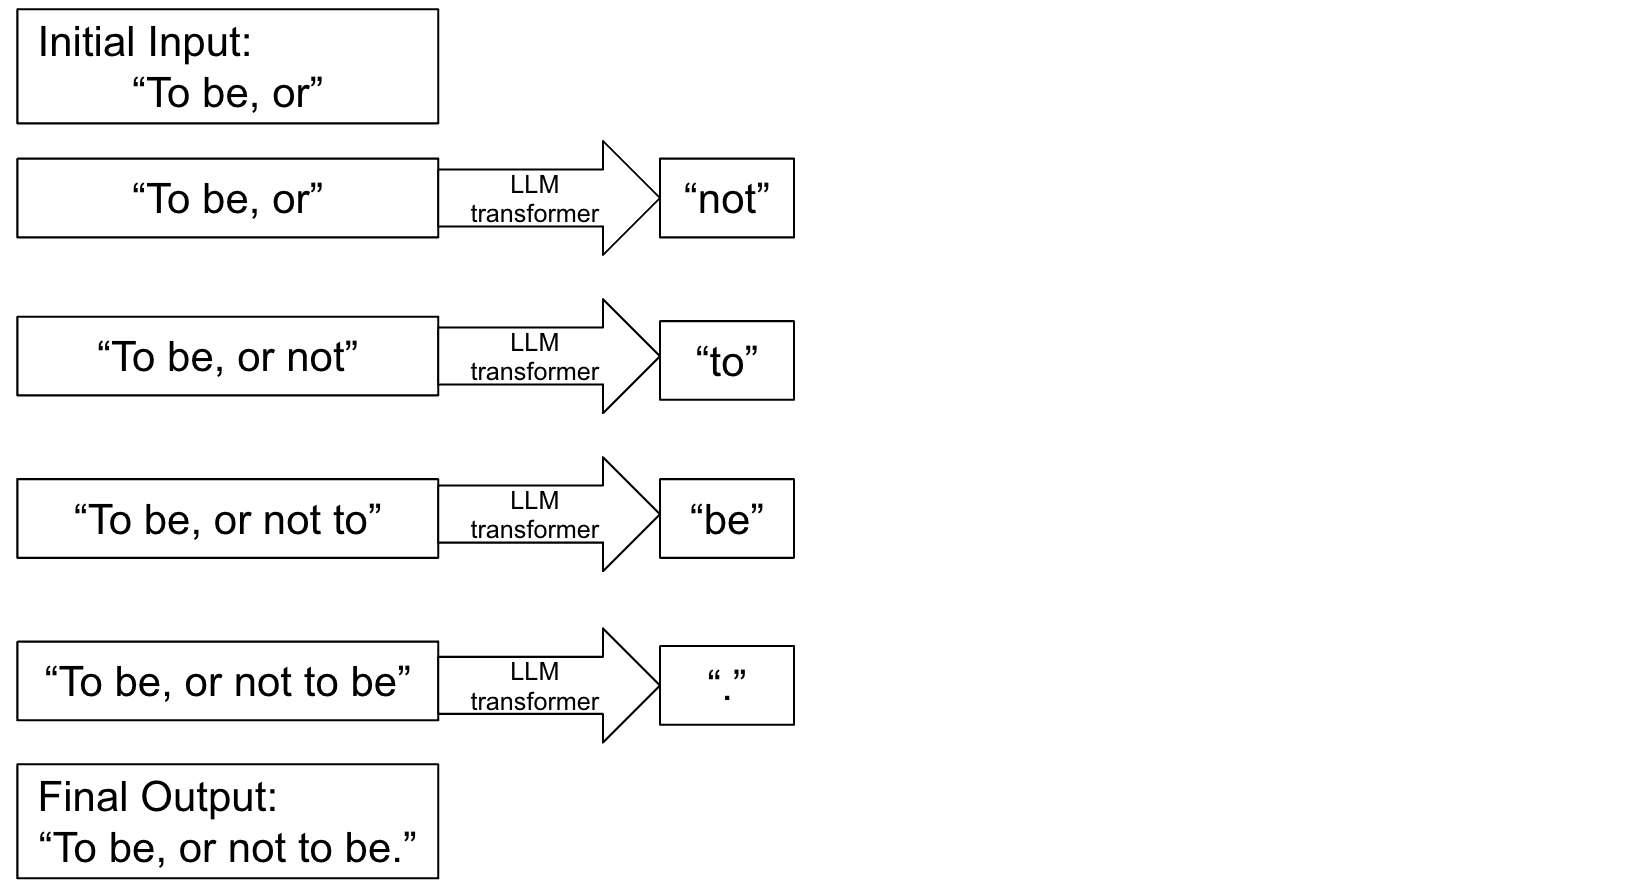

## Start Training Your Own NanoGPT on Shakespeare


The training data for NanoGPT is all of Shakespeare's plays. For simplicity, the tokens used for this model are English letters rather than English words.

So, the NanoGPT is going to predict the next possible English letter based on the input sequence rather than words. For example, if our initial input is "T", the model could predict the next possible letter to be "h", then to be "e", and to an empty space " ". If an empty space " " is our desired end, then the final output of the model will be "The ".

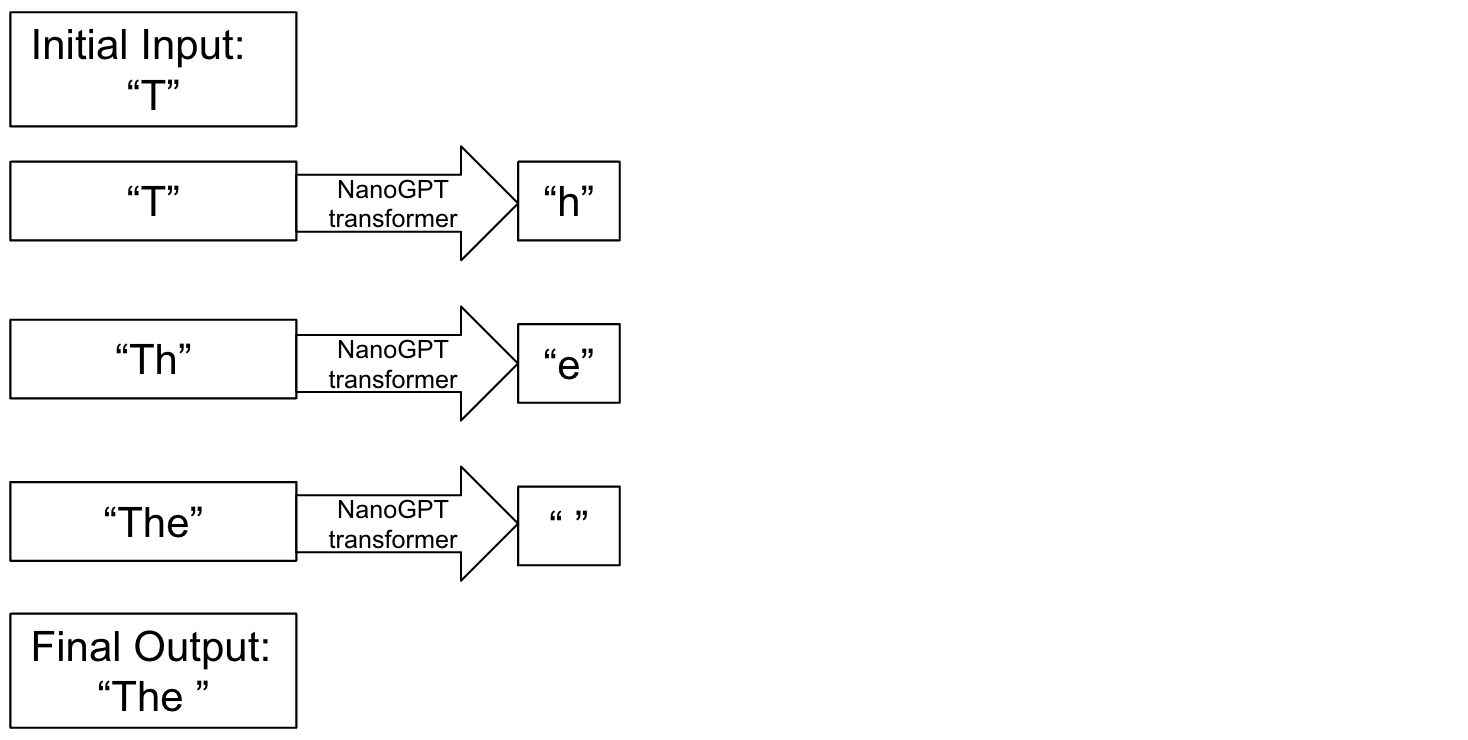

### Essential Libraries


In [1]:
%pip install aitk --upgrade --quiet

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import nltk
from nltk.corpus import words
import os
from aitk.utils.datasets import nanoGPT_shakespeare

### Loading the dataset

In [3]:
# Download the shakespeare texts from aitk dataset
input_text = nanoGPT_shakespeare.get_dataset("shakespeare texts")

with open(input_text, 'r', encoding='utf-8') as f:
    text = f.read()

Let's see how many letters there are in the combined texts of all of Shakespear's plays.

In [4]:
len(text)

1115394

Each epoch of training will be trying to predict sequences of these over 1 million letters.

### Tunable Parameters

In [5]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
current_epoch = 0
# ------------

In [6]:
#@title Model Definition
torch.manual_seed(1337)

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model/ NanoGPTLanguageModel
class NanoGPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    # start generation for texts
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

# function to train the model
def training(training_epochs):
  # indicate current_epoch as global
  global current_epoch

  # print the number of parameters in the model
  print(sum(p.numel() for p in model_in_device.parameters())/1e6, 'M parameters')

  # create a PyTorch optimizer
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

  # the max epochs the model trains to
  max_iters = current_epoch + training_epochs

  # set up the training loop
  for iter in range(current_epoch, max_iters):

      # every once in a while evaluate the loss on train and val sets
      if iter % eval_interval == 0 or iter == max_iters - 1:
          losses = estimate_loss()
          print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

      # sample a batch of data
      xb, yb = get_batch('train')

      # evaluate the loss
      logits, loss = model(xb, yb)
      optimizer.zero_grad(set_to_none=True)
      loss.backward()
      optimizer.step()

  # update current epochs to a new number
  current_epoch += training_epochs

# word_counter function definition
# Ensure the 'words' corpus is downloaded
nltk.download('words')

def testing():
  # Your custom input text
  input_text = input("Enter the initial input for your NanoGPT: ")

  # Encode the input text
  input_tokens = encode(input_text)

  # Convert tokens to tensor
  context = torch.tensor([input_tokens], dtype=torch.long, device=device)

  # generate from the model
  output = decode(model_in_device.generate(context, max_new_tokens=2000)[0].tolist())
  print()
  print("Output from NanoGPT: ")
  print(output)
  return output

def word_counter(input):
  output_words = input.split()

  # Get the list of valid English words
  english_words = set(words.words())

  # Count the number of correctly spelled words
  correctly_spelled_words = [word for word in output_words if word.lower() in english_words]
  correct_count = len(correctly_spelled_words)
  total_count = len(output_words)

  # Print the results
  print(f"Total words: {total_count}")
  print(f"Correctly spelled words: {correct_count}")
  print(f"Percentage of correctly spelled words: {correct_count / total_count * 100:.2f}%")

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


### Creating an Instance of the Model

In [7]:
model = NanoGPTLanguageModel()
model_in_device = model.to(device)

Congratulations! You have just created your own NanoGPT. Let's see how it performs.

Before we run the model, we can specify its initial input so that the model is able to give its predictions. Leaving the inputs blank will default the input sequence to be a blank space.

In [8]:
output = testing()

Enter the initial input for your NanoGPT: To thine own

Output from NanoGPT: 
To thine ownlr
oOSbrDkvnqFsG!yaVlpNAA'33YI-uNVbqwsjAbjXOAAIeHkhqUN3qUUsHw-&DbFch:t..JPAWVU!nAtyvUYAFWCd!ngOEo.$A,!NJIyVrrU&bO,J
D33xiyDecfNCKoLj?rcX?CeTUNUKuneG-UUo&pDthqGiCDuUpn?O
ppDzx'p&pRczecVGAzqsnR'XuHJxngBc$onocJuElncX:,CEWw-?bG-AtPZp;bCioC
yCm$yGAicrq3xz:d3iQeV&NH.qlS'HDetj-LR;;!k-pbIo$Vczfd!Dw!$XeNNCo-cADCQ-jH.Jgwzt.HktLfDJ,PGNAFpKNP;mtg.KRkXvAYDcAkWTwOhquYcAzIo!,V;hTOZVKZJDhoAi;ShqJfEyZpbSoh!U:,v;mJ?HiogMaRoC,s!RSUoUwuo?ibte-&?KgmGz:CXe?JVaU&ROjc&.Y
LU
iawJesdMBO!dGedMp 3!bC$foTJno!qMDFZjUyruCOoeA!zlneVcPpXhggH3gGIovd;VDXz?UJTRKK!NLe$Yzl,By-Q$,Vi-&jy.Egg?R,oPRVutfVKI,m-oh'. RTebSK!FT-WoE'cUSihD!edzLoJicyX;OyFcJs.tLENwNw?dlL.v?nxrb?RZvLwuUf$CUgwBipXogo.eXeR.3KUoO!h!R..U!LeINvQ'KUoL.Gz'JCqP&UFsCgothK3p:DXK:fWApz-zDv,NEjJEu$f wjo,Z p3DoA,pRLIwkBczhxEsTZJvwJw:uNUTJ!De,Ocnxm.&;ADQbhXfLSp:eztWDKcUvjvtQoOoy?-?s$d?JciyquJPN,cE;fyKh,nhyN$&LNUU$!Jc! sVek&UL;ykYTpdiWObbwSu,tWK,pSUZoKbcp?X,NZOcoHJVpVL&mRQF$pZFn

This does not look like Shakespeare at all! Let't analyze it using a word count function.

In [9]:
word_counter(output)

Total words: 38
Correctly spelled words: 2
Percentage of correctly spelled words: 5.26%


After runing the word counter function, you will see a close to 0% correctness. It is likely that the only words it got right were the ones that you provided in the initial prompt. This is because we haven't trained the model yet so it's just outputting gibberish Let's start training!

### Training

Initially we will train the model for 1000 epochs. This proccess should take approximatly 2 mins.

Watch the progress of the training below. We would expect the training loss to drop over time. This reflects the amount of error the model is making in its prediction task. While you're waiting, scroll back up and look at the initial testing output. Notice that it isn't just producing letters, but also punctuation, spaces, and newlines.

In [10]:
training(1000)

0.209729 M parameters
step 0: train loss 4.4077, val loss 4.4024
step 100: train loss 2.6498, val loss 2.6510
step 200: train loss 2.4997, val loss 2.4976
step 300: train loss 2.4218, val loss 2.4229
step 400: train loss 2.3468, val loss 2.3601
step 500: train loss 2.2951, val loss 2.3150
step 600: train loss 2.2490, val loss 2.2617
step 700: train loss 2.2046, val loss 2.2161
step 800: train loss 2.1576, val loss 2.1919
step 900: train loss 2.1368, val loss 2.1679
step 999: train loss 2.0971, val loss 2.1313


In [11]:
output = testing()

Enter the initial input for your NanoGPT: To thine own

Output from NanoGPT: 
To thine ownt, shor poving pet.

CLLANKENYCLARD:
So enecir, that prargiiounceltong brrong,
SI'll thee flith yould breichan hew lifieren the efurehill tham.

ORD VORKEES:
In meince:
Ay knot'll and fory'e barot wenche.'d prewst henvearbpoore
thefffor se tenfureor on and half
Telfors; Tecoures yould sof, meak breirs kere
ner, to plomers astrermern ingies.

Thur comend your becel willsAn you.

MELRUKIV:
BKlfaarl;
Frly wars my dimiven:
Thathe moh ear were so no avee with mranysur,
Whe buand poorer and Yor wour deing vlave uss,
Witll filll heacht I halfare etcee,
Vail fak, ey beat muon pines rimear yore Hint, her his yest then too the bealfathan ming andppard.

YRORTYSTher hencens fally to furt histachis my aid ware:
Whelt:
That nashelline, heard nope you hir he woll haver
te ewher wa efier engrart geast 
Prighponey Oor and beeaten.o, theren pentlyseien prent bry gin treair?
Arled my mey unwerore and wetsill,;
Fill

After some intial training, the output is starting to look much more like a Shakespeare play, with character names in all caps, followed by some dialog. However, it looks like the model hasn't yet grasped the correct spelling of most words.

In [12]:
word_counter(output)

Total words: 325
Correctly spelled words: 117
Percentage of correctly spelled words: 36.00%


The word count function should indicate that NanoGPT spells the words correctly for around 35% of the time.

Let's train the model for 2000 more epochs and see how it performs. This should take for about 3 mins. The training loss should drop even more this time.

In [13]:
training(2000)

0.209729 M parameters
step 1000: train loss 2.0969, val loss 2.1305
step 1100: train loss 2.0652, val loss 2.1011
step 1200: train loss 2.0347, val loss 2.0751
step 1300: train loss 2.0111, val loss 2.0610
step 1400: train loss 1.9854, val loss 2.0551
step 1500: train loss 1.9750, val loss 2.0334
step 1600: train loss 1.9556, val loss 2.0307
step 1700: train loss 1.9424, val loss 2.0154
step 1800: train loss 1.9244, val loss 2.0079
step 1900: train loss 1.9080, val loss 2.0062
step 2000: train loss 1.8915, val loss 1.9808
step 2100: train loss 1.8896, val loss 1.9805
step 2200: train loss 1.8673, val loss 1.9569
step 2300: train loss 1.8571, val loss 1.9629
step 2400: train loss 1.8433, val loss 1.9446
step 2500: train loss 1.8377, val loss 1.9514
step 2600: train loss 1.8214, val loss 1.9298
step 2700: train loss 1.8177, val loss 1.9283
step 2800: train loss 1.8100, val loss 1.9293
step 2900: train loss 1.8067, val loss 1.9337
step 2999: train loss 1.7884, val loss 1.9294


Start generating outputs from NanoGPT:

In [14]:
output = testing()

Enter the initial input for your NanoGPT: To thine own

Output from NanoGPT: 
To thine own my knows with
ell hase bleefing: and by beson, and with a usher:
Of me wach, Pold meat heaven rignand
As lead thiss chepom 't you! as smeliesmed.
The cands, and but his lay
Their haw hathem, of let thee hathere slaped;
To eaurse Sawn the some lird to teass whads lesat's to choursed annigen:
The mane by grave not nobt that?

ABELINA:
I hape time that; where may work?
And brisst make shee haminim the lasching out-rath, hoursellireshem you.

CORICEN'ENIO:
Least:
My subce, for this him.

TULIies make comespirit our kpoys yet ent Henem greasign tabe agentage:
And to which, amand, how untle that he some that mistre knimples wong.
He hered as this light wing, my with thinkle in, for hearse dide a knight,
Pring was while brack dings and watherfulse whriek!

LARD IV:
Hou way, on must lord: why here, for is my baviss:
Bot, he wantle, and me come. 
I while hold is and anger, dier fing chisg?

FRYORIS:
Let n

The model is able to grasp some of the spelling, but it is still not perfect. In order to get better results you would need to train the model for more epochs and with larger batch and block sizes using better hardware.

In [15]:
word_counter(output)

Total words: 368
Correctly spelled words: 201
Percentage of correctly spelled words: 54.62%


It looks like now it spells the words right for about 50% of the time.

### Loading from Pre-trained Model

Here is a pre-trained model that we have trained using better hardware for around 15000 epochs. Let's load it and see how it performs. The text generation may take about 1 min.

In [16]:
# Download the shakespeare texts from aitk dataset
saved_model_path = nanoGPT_shakespeare.get_dataset("saved model")

# Loading model
saved_model = torch.load(saved_model_path, map_location=device)
model_in_device = saved_model.to(device)

Start generating outputs from NanoGPT:

In [17]:
output = testing()

Enter the initial input for your NanoGPT: To thine own

Output from NanoGPT: 
To thine own. Lautentio
And all to notous so advise as Master served,
Have pass'd flower our safegrace!
For Edward ward's take; for night
I will play the learted since your daughter to good on.

Page:
Gat holy frick in
d this armous; I'll burn you, helpk's none.

FLORIZEL:
He would they
were they discove a charge to be no growther golden on hell!
Thus returning marry; one play'd your along.
To have said, the heavens' depugater them monty
Of their two days, for a great still plant;
I'll give my tribe with me; been spotless beseeming
house,
awakers much themselves. Come, my gracious son.

MARCIUS:
How! what aufidius to-murdinantly feell,
Have to prison a thorny to avengeansman's mouth!
I'll prase you, think to entreat you.

CORIOLANUS:
Saw you be the night?

Messenger:
He: would you have you lose this god.

OXFORD:
Ay, one quarrel a traitor, which is the onest horses,
Richard, in him all-fint all his night
Give

In [18]:
word_counter(output)

Total words: 354
Correctly spelled words: 226
Percentage of correctly spelled words: 63.84%


The model's spelling correctness should improve to nearly 70% correctness. Despite its improved spelling, it's likely that the combination of words it produces still don't make much sense.

Feel free to scroll back up and try a different prompt.

## Conclusion

Despite having the ability to mimick Shakespearen style text, our NanoGPT uses less training data (only Shakespeare texts) and a simplified transformer architecture, compared with other LLMs like ChatGPT. NanoGPT is a smaller model that is less capable of learning complex patterns.

Unlike ChatGPT which uses word-like tokens, NanoGPT uses letters as tokens. For example, the tokens that NanoGPT uses are "a", "b", and "c" while ChatGPT might be using "apple", "banana", and "car". So, instead of predicting the next possible word, NanoGPT is predicting the next possible English letter based on the input sequence.

The use of English letters as tokens simplifies a lot of things, but also impacts the performance of the model. This is the reason why our NanoGPT does not seem to form meaningful sequences of words. Rather, it seems to be doing a good job of just creating words.

You may be wondering why NanoGPT doesn't seem to respond appropriately to prompts as ChatGPT does. The reason for this is that ChatGPT has gone through a fine tuning process so that it has learned how to interact with humans in a conversational manner. The fine tuning is done using a combination of reinforcement and supervised learnig. Without this fine turning, the LLM will only be a document completer. It is only trying to predict the next word-like tokens based on the context that it is given. We call this type of transformer a pre-trained transformer. So, the NanoGPT that we just built is only a pre-trained transformer.

We hope that this exploration of NanoGPT has given you some insights into how large language models like ChatGPT work.

## References

[1] 3Blue1Brown. Attention in Transformers, Visually Explained | Chapter 6, Deep Learning. 2024. YouTube, https://www.youtube.com/watch?v=eMlx5fFNoYc.

[2] 3Blue1Brown. But What Is a GPT?  Visual Intro to Transformers | Chapter 5, Deep Learning. 2024. YouTube, https://www.youtube.com/watch?v=wjZofJX0v4M.

[3] Andrej Karpathy. [1hr Talk] Intro to Large Language Models. 2023. YouTube, https://www.youtube.com/watch?v=zjkBMFhNj_g.

[4] Andrej Karpathy. Let’s Build GPT: From Scratch, in Code, Spelled Out. 2023. YouTube, https://www.youtube.com/watch?v=kCc8FmEb1nY.

[5] Erdem (burnpiro), Kemal. “Understanding Positional Encoding in Transformers.” Medium, 13 May 2021, https://towardsdatascience.com/understanding-positional-encoding-in-transformers-dc6bafc021ab.

[6] Gupta, Yashu. “Chat GPT and GPT 3 Detailed Architecture Study-Deep NLP Horse.” Nerd For Tech, 16 Mar. 2023, https://medium.com/nerd-for-tech/gpt3-and-chat-gpt-detailed-architecture-study-deep-nlp-horse-db3af9de8a5d.


[7] Karpathy, Andrej. “nanoGPT.” Github, https://github.com/karpathy/nanoGPT. Accessed 17 July 2024.


[8] Karpathy, Andrej. “Ng-Video-Lecture/Gpt.Py at Master · Karpathy/Ng-Video-Lecture.” GitHub, https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py. Accessed 17 July 2024.

[9] “Let’s Read: Transformer Models, Part 2.” A Trivial Knot, 7 Jan. 2024, https://freethoughtblogs.com/atrivialknot/2024/01/07/lets-read-transformer-models-part-2/.

[10] Stanford Online. Stanford XCS224U: NLU I Contextual Word Representations, Part 3: Positional Encoding I Spring 2023. 2023. YouTube, https://www.youtube.com/watch?v=JERXX2Byr90.

[11] StatQuest with Josh Starmer. Transformer Neural Networks, ChatGPT’s Foundation, Clearly Explained!!! 2023. YouTube, https://www.youtube.com/watch?v=zxQyTK8quyY.

[12] Vaswani, Ashish, et al. Attention Is All You Need. arXiv:1706.03762, arXiv, 1 Aug. 2023. arXiv.org, https://doi.org/10.48550/arXiv.1706.03762.


### Note

This is a modifications and adaptation on Andrej Karpathy's nanoGPT, here is his github repos again:

https://github.com/karpathy/nanoGPT

https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py


MIT License

## Additional Notebooks


To learn more about transformer in more details, you can check out our notebook on transformers.